In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resnet50-v1/restnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/efficientnetb0/efficientnetb0_notop.h5
/kaggle/input/ai-1803-dpl-302-m-butterfly-image-classification/Training_set.csv
/kaggle/input/ai-1803-dpl-302-m-butterfly-image-classification/test/test/Image_747.jpg
/kaggle/input/ai-1803-dpl-302-m-butterfly-image-classification/test/test/Image_561.jpg
/kaggle/input/ai-1803-dpl-302-m-butterfly-image-classification/test/test/Image_345.jpg
/kaggle/input/ai-1803-dpl-302-m-butterfly-image-classification/test/test/Image_844.jpg
/kaggle/input/ai-1803-dpl-302-m-butterfly-image-classification/test/test/Image_270.jpg
/kaggle/input/ai-1803-dpl-302-m-butterfly-image-classification/test/test/Image_526.jpg
/kaggle/input/ai-1803-dpl-302-m-butterfly-image-classification/test/test/Image_968.jpg
/kaggle/input/ai-1803-dpl-302-m-butterfly-image-classification/test/test/Image_322.jpg
/kaggle/input/ai-1803-dpl-302-m-butterfly-image-classification/test/test/Image_860

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
import shutil
import time
from sklearn.metrics import classification_report

In [32]:
# Path dataset
train_csv = "/kaggle/input/ai-1803-dpl-302-m-butterfly-image-classification/Training_set.csv"
train_folder = "/kaggle/input/ai-1803-dpl-302-m-butterfly-image-classification/train/train"
test_folder = "/kaggle/input/ai-1803-dpl-302-m-butterfly-image-classification/test/test"

train_df = pd.read_csv(train_csv)

In [33]:
print(train_df)

            filename                     label
0        Image_1.jpg          SOUTHERN DOGFACE
1        Image_2.jpg                    ADONIS
2        Image_3.jpg            BROWN SIPROETA
3        Image_4.jpg                   MONARCH
4        Image_5.jpg  GREEN CELLED CATTLEHEART
...              ...                       ...
4995  Image_4996.jpg                ORANGE TIP
4996  Image_4997.jpg                   MONARCH
4997  Image_4998.jpg           GREY HAIRSTREAK
4998  Image_4999.jpg                   MONARCH
4999  Image_5000.jpg         COMMON BANDED AWL

[5000 rows x 2 columns]


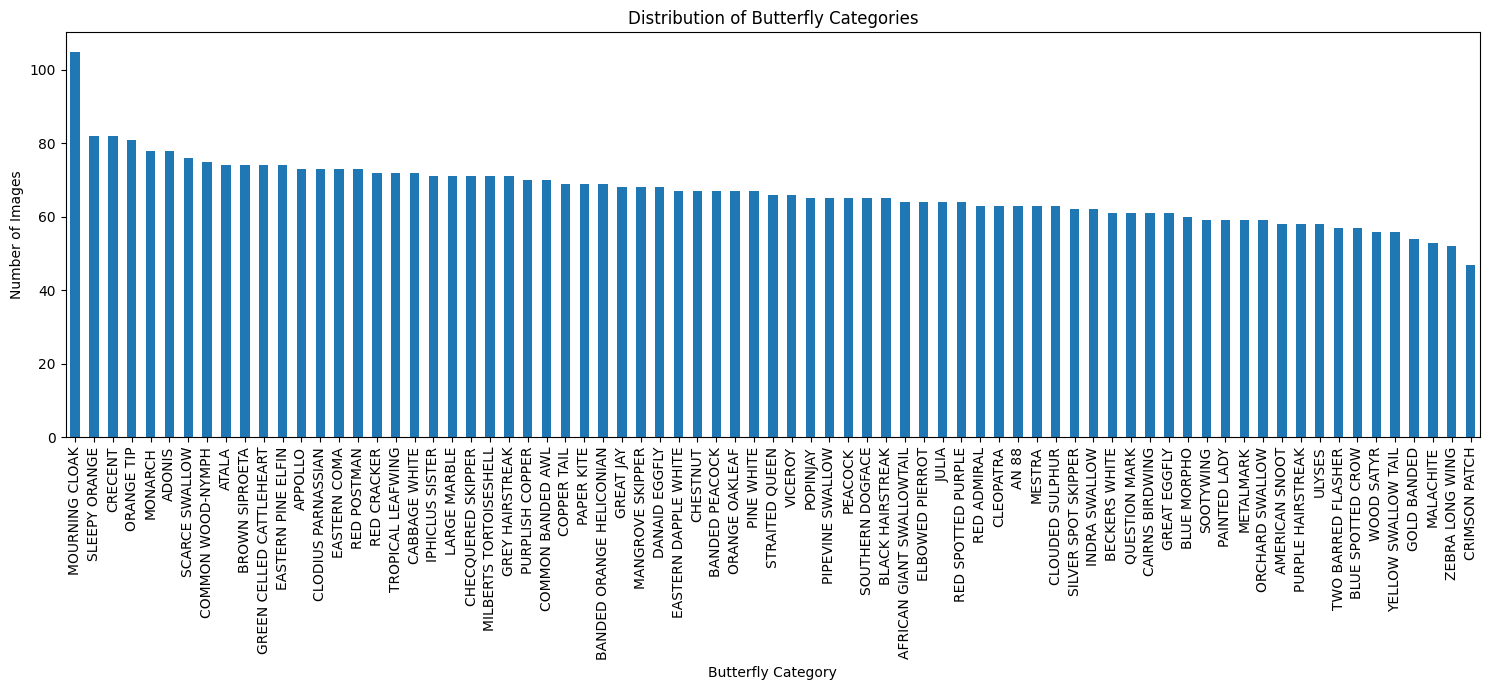

In [34]:
plt.figure(figsize=(15, 7))
train_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Butterfly Categories')
plt.xlabel('Butterfly Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [35]:
## Hyperparameter
image_size = (240, 240)
batch_size = 32
epochs = 100
learning_rate = 0.0001


class_name = list(set(train_df['label']))
print(class_name)

['EASTERN PINE ELFIN', 'CLOUDED SULPHUR', 'VICEROY', 'ADONIS', 'MONARCH', 'TROPICAL LEAFWING', 'EASTERN DAPPLE WHITE', 'STRAITED QUEEN', 'MOURNING CLOAK', 'AMERICAN SNOOT', 'SOOTYWING', 'BLACK HAIRSTREAK', 'MESTRA', 'CHECQUERED SKIPPER', 'YELLOW SWALLOW TAIL', 'GREEN CELLED CATTLEHEART', 'COPPER TAIL', 'MANGROVE SKIPPER', 'MALACHITE', 'GOLD BANDED', 'CLODIUS PARNASSIAN', 'BECKERS WHITE', 'WOOD SATYR', 'PAINTED LADY', 'BROWN SIPROETA', 'DANAID EGGFLY', 'ULYSES', 'CRIMSON PATCH', 'INDRA SWALLOW', 'POPINJAY', 'CLEOPATRA', 'GREY HAIRSTREAK', 'PIPEVINE SWALLOW', 'SOUTHERN DOGFACE', 'AFRICAN GIANT SWALLOWTAIL', 'ZEBRA LONG WING', 'GREAT EGGFLY', 'PEACOCK', 'SCARCE SWALLOW', 'IPHICLUS SISTER', 'BANDED PEACOCK', 'PINE WHITE', 'CAIRNS BIRDWING', 'CABBAGE WHITE', 'COMMON BANDED AWL', 'EASTERN COMA', 'RED ADMIRAL', 'TWO BARRED FLASHER', 'QUESTION MARK', 'CHESTNUT', 'RED POSTMAN', 'PURPLISH COPPER', 'PAPER KITE', 'PURPLE HAIRSTREAK', 'JULIA', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'CRECENT', 'ATALA',

In [36]:
features = []
labels = []

for image in tqdm(os.listdir(train_folder), desc="Preprocess Image") :
    label_name = train_df.loc[train_df['filename'] == image, 'label'].values[0]
    label = class_name.index(label_name)
    image_read = cv2.imread(os.path.join(train_folder, image))
    image_resized = cv2.resize(image_read, image_size)
    image_normalized = image_resized / 255.0
    features.append(image_normalized)
    labels.append(label)

Preprocess Image: 100%|██████████| 5000/5000 [00:45<00:00, 110.93it/s]


In [37]:
print(len(features))
print(len(labels))

features = np.asarray(features)
labels = np.asarray(labels)

5000
5000


In [38]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

In [39]:
del features
del labels

In [40]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = MobileNetV2(
    weights='/kaggle/input/mobilenet/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5', 
    include_top=False, 
    input_shape=(image_size[0], image_size[1], 3)
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(75, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy to match label format
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_mobilenetv2.keras', monitor='val_loss', save_best_only=True)


In [41]:
# Measure the training time
start_time = time.time()

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 107s 922ms/step - accuracy: 0.0679 - loss: 4.2362 - val_accuracy: 0.2747 - val_loss: 3.4678
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 92s 834ms/step - accuracy: 0.4134 - loss: 3.0809 - val_accuracy: 0.5120 - val_loss: 2.5203
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 94s 855ms/step - accuracy: 0.6304 - loss: 2.0721 - val_accuracy: 0.5853 - val_loss: 1.9122
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 94s 852ms/step - accuracy: 0.7491 - loss: 1.4927 - val_accuracy: 0.6960 - val_loss: 1.5398
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 92s 838ms/step - accuracy: 0.8024 - loss: 1.1326 - val_accuracy: 0.7413 - val_loss: 1.3136
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 94s 855ms/step - accuracy: 0.8463 - loss: 0.8937 - val_accuracy: 0.7533 - val_loss: 1.1713
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 106s 965ms/step - accuracy: 0.8905 - loss: 0.7138 - val_accuracy: 0.7640 - val_loss: 1.0871
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 92s 839ms/step - accuracy: 0.9135

In [51]:
end_time = time.time()

training_time = (end_time - start_time)/3600

print(training_time)

1.6499377901686563


In [52]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 675ms/step - accuracy: 0.8638 - loss: 0.4713
Test loss: 0.5601
Test accuracy: 0.8440


In [53]:
# Create a list to store the results
test_images = []
test_filenames = []

for image_name in os.listdir(test_folder):
    image_path = os.path.join(test_folder, image_name)
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, image_size)
    image_normalized = image_resized / 255.0
    test_images.append(image_normalized)
    test_filenames.append(image_name)


In [55]:
# Convert list to numpy array
test_images = np.array(test_images)


In [56]:
# Predict labels for test images
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)


47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 746ms/step


In [57]:

predicted_class_names = [class_name[label] for label in predicted_labels]

results_df = pd.DataFrame({
    'ID': test_filenames,
    'label': predicted_class_names
})

In [58]:

print(results_df.head(10))

               ID                   label
0   Image_747.jpg         ELBOWED PIERROT
1   Image_561.jpg  MILBERTS TORTOISESHELL
2   Image_345.jpg              PINE WHITE
3   Image_844.jpg      TWO BARRED FLASHER
4   Image_270.jpg      CHECQUERED SKIPPER
5   Image_526.jpg         ORCHARD SWALLOW
6   Image_968.jpg           CRIMSON PATCH
7   Image_322.jpg            GREAT EGGFLY
8   Image_860.jpg               CLEOPATRA
9  Image_1103.jpg         ELBOWED PIERROT


In [62]:
# Lưu kết quả vào file CSV
results_df.to_csv('/kaggle/working/Testing_set.csv', index=False)


In [63]:
import os

print(os.listdir('/kaggle/working'))


['best_model_mobilenetv2.keras', 'butterfly_classification_results.xlsx', '.virtual_documents', 'Testing_set.csv']
